In [25]:
import sys
sys.path.extend(['C:\\Users\\Max\\Dropbox\\Projects\\GPRDD'])
sys.path.extend(['C:\\Users\\u341138\\Dropbox\\Projects\\GPRDD'])
sys.path.extend(['C:\\Users\\Max Hinne\\Dropbox\\Projects\\GPRDD'])

import GPy
import numpy as np
import matplotlib.pyplot as plt

import GPRDDAnalysis

print("GPy version:      {}".format(GPy.__version__))
print("GPRDD version:    {}".format(GPRDDAnalysis.__version__))

GPy version:      1.9.6
GPRDD version:    0.0.3


In [26]:
def get_kernel(kerneltype, D):

    if kerneltype == 'Matern32':
        kernel = GPy.kern.Matern32(D) + GPy.kern.White(D)
    elif kerneltype == 'Linear':
        kernel = GPy.kern.Linear(D) + GPy.kern.Bias(D) + GPy.kern.White(D)
    elif kerneltype in ('ttest', 'Constant'):
        kernel = GPy.kern.Bias(D) + GPy.kern.White(D)
    elif kerneltype == 'RBF':
        kernel = GPy.kern.RBF(D) + GPy.kern.White(D)
    else:
        raise('Unsupported kernel type')
    return kernel.copy()
#

# The 1-dimensional case
The labelFunc object is a function of the input $x$ that assigns a label $l = f(x)$. It can be a simple threshold in classical RDD or any arbitrary function.

In [27]:
def generate_data_1D(labelFunc, n=10, snr=1.0):    
    xmin    = -1.5
    xmax    = 1.5
    x       = np.linspace(xmin, xmax, num=n)    
    noise   = np.random.normal(size=n)    
    gap     = snr
    
    b0, b1, b2 = (5, 1.2, 0.0)
    y = b0 + b1*x + b2*np.sin(x) + noise
    
    labels = labelFunc(x)
    y[labels] += gap
    
    return x, y, labels
#

labelFunc = lambda x: x > 0
x, y, _ = generate_data_1D(labelFunc, n=25, snr=3.0)   

We construct a $D$-dimensional kernel, and train the GP RDD model, i.e. optimize hyperparameters for both models.

In [28]:
D = 1
kernel = get_kernel(kerneltype='Matern32', D=D)
gprdd = GPRDDAnalysis.GPRDDAnalysis(x, y, kernel, labelFunc)
gprdd.train()

To conclude the presence/absence of an effect, we evaluate the continuous and discontinuous models on test data, and compute the Bayes factor $$BF_{DC}=\frac{p(x,y\mid M_{Disc})}{p(x,y\mid M_{Cont})}$$ based on the observed data. Note that computing the required model evidence terms is intractable (it requires integrating out the hyperparameters of the GP kernel), so instead we compute the [Bayesian Information Criterion](https://en.wikipedia.org/wiki/Bayesian_information_criterion) (BIC): $$\log p(x,y\mid M_i) \approx \log{\hat{L}} + 2k\log{n} \enspace,$$ where $\hat{L}$ is the likelihood with *optimized* hyperparameters, $k$ is the number of parameters of the model and $n$ the number of observations. 

### Regression discontinuity design
The primary application of our method is regression discontinuity design, which would result in the following report:

 C:\Users\Max\Anaconda3\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1


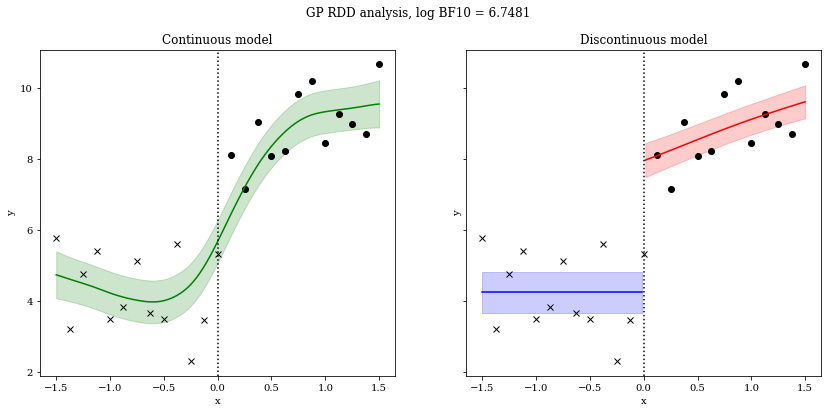

In [29]:
x_test = np.linspace(-1.5, 1.5, num=100)  
gprdd.plot(x_test)

Negative Bayes factors provide evidence for the null model (no discontinuity); positive Bayes factors provide for a discontinuity.

### Difference-within-differences
We can also use the approach to detect e.g. differences in slope. This method is known as *difference-within-differences*. For example:

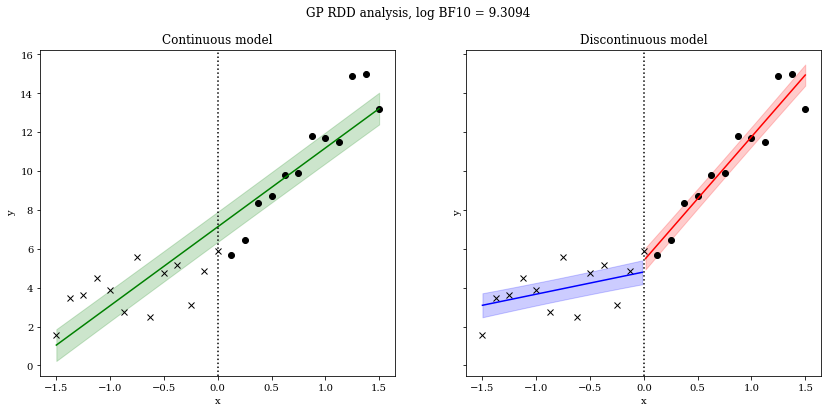

In [30]:
def generate_data_1D_diffslope(n, labelFunc, slopeRatio=2.0):    
    xmin    = -1.5
    xmax    = 1.5
    x       = np.linspace(xmin, xmax, num=n)    
    noise   = np.random.normal(size=n)   
    
    b0, b1= (5, 1.7)
    y = b0 + b1*x*np.logical_not(labelFunc(x)) + b1*slopeRatio*x*labelFunc(x) + noise
    
    labels = labelFunc(x)
    
    return x, y, labels
#
x, y, _ = generate_data_1D_diffslope(25, labelFunc, slopeRatio=4.0)      

kernel = get_kernel(kerneltype='Linear', D=D)
gprdd = GPRDDAnalysis.GPRDDAnalysis(x, y, kernel, labelFunc)
gprdd.train()
gprdd.plot(x_test)

Rather than a discontinuity, here we find evidence suggesting a difference in slopes pre- and post threshold.

### Subsuming a t-test
When we use simply a bias/constant kernel, we essentially use a sophisticated tool to fit a univariate Gaussian distribution. The RDD then becomes equivalent to a t-test, which demonstrates how generic the method is. Consider:

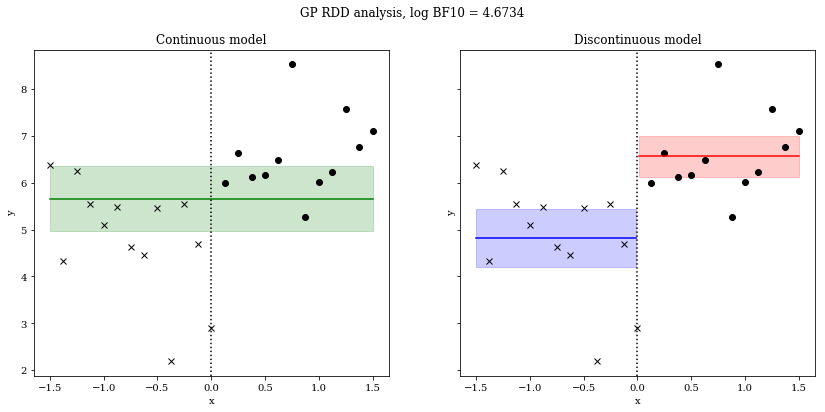

In [31]:
def generate_data_1D_const(n, labelFunc, gap=2.0):    
    xmin    = -1.5
    xmax    = 1.5
    x       = np.linspace(xmin, xmax, num=n)    
    noise   = np.random.normal(size=n)   
    
    b0, b1= (5, 0.0)
    y = b0 + noise
    
    labels = labelFunc(x)
    y[labels] += gap
    
    return x, y, labels
#
x, y, _ = generate_data_1D_const(25, labelFunc, gap=2.0)      

kernel = get_kernel(kerneltype='ttest', D=D)
gprdd = GPRDDAnalysis.GPRDDAnalysis(x, y, kernel, labelFunc)
gprdd.train()
gprdd.plot(x_test)

# 2-dimensional case

In [32]:
def generate_data_2D(labelFunc, n=50, snr=1.0):       
    xmin    = -1.5
    xmax    = 1.5
    x      = np.random.uniform(xmin, xmax, size=(n, 2))          
    noise   = np.random.normal(size=n)    
    gap     = snr
    
    b = np.array([5, 1.2, 1.8])
    b = np.expand_dims(b, axis=1)
    y = np.squeeze(b[0] + b[1:,].T @ x.T + noise)
    
    labels                 = labelFunc(x)
    y[labels] += gap
    y = np.expand_dims(y, axis=1)
    
    return x, y, labels
#

labelFunc = lambda x: np.logical_and(x[:,0] < 0, x[:,1] > 0)
x, y, _ = generate_data_2D(labelFunc, n=100, snr=3.0)

Again, we construct a $D$-dimensional kernel, and train the GP RDD model, i.e. optimize hyperparameters for both models.

In [33]:
D = 2
kernel = get_kernel(kerneltype='Matern32', D=D)
gprdd = GPRDDAnalysis.GPRDDAnalysis(x, y, kernel, labelFunc)
gprdd.train()

And again we evaluate it on test data and compute the RDD Bayes factor.

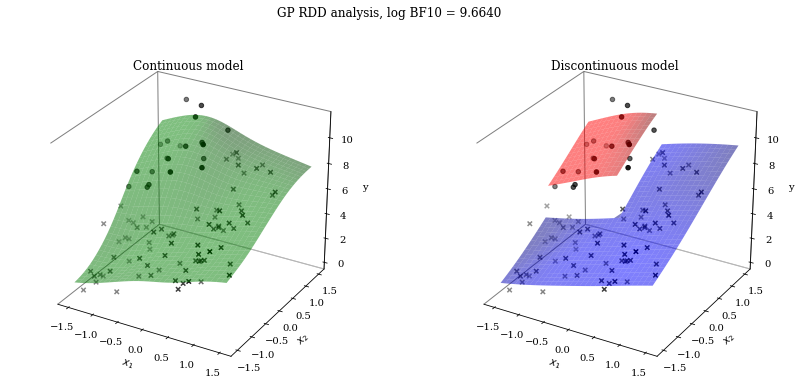

In [34]:
n_test = 1000
xx = np.linspace(-1.5, 1.5, num=np.sqrt(n_test))
X, Y = np.meshgrid(xx, xx)
x_test = np.array([X.flatten(), Y.flatten()]).T

gprdd.plot(x_test)